In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
print("All good")

All good


In [10]:
# Cell 2: Load Image and Setup Pose Estimation
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Load your image
image_path = 'baseball_player1.jpg'  # change if needed
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


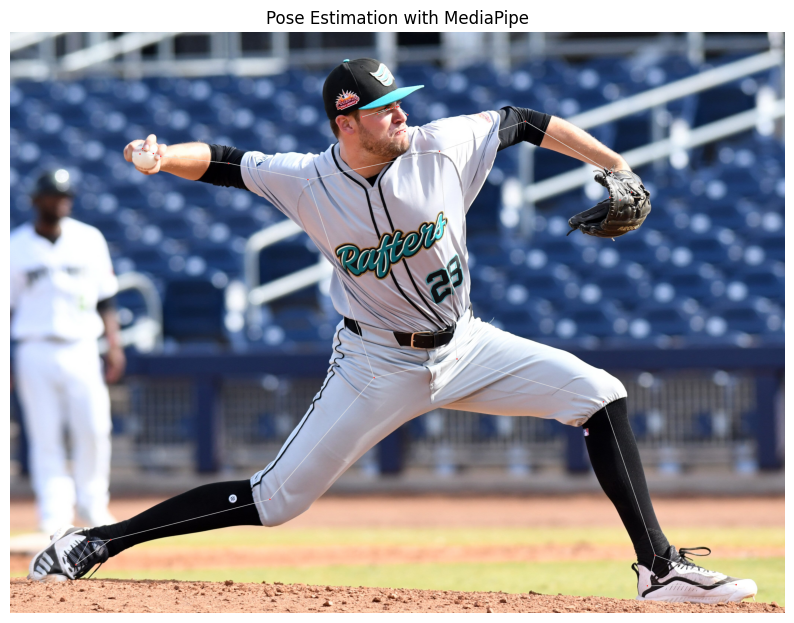

In [11]:
# Cell 3: Run pose estimation
with mp_pose.Pose(static_image_mode=True, model_complexity=2) as pose:
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(
            annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Convert BGR to RGB for display
        annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

        # Display the image
        plt.figure(figsize=(10, 10))
        plt.imshow(annotated_image_rgb)
        plt.axis('off')
        plt.title('Pose Estimation with MediaPipe')
        plt.show()
    else:
        print("No person detected.")


In [12]:
# Cell 4: Extract keypoints of interest

# Define key joints we care about
keypoints_of_interest = {
    "LEFT_SHOULDER": mp_pose.PoseLandmark.LEFT_SHOULDER,
    "RIGHT_SHOULDER": mp_pose.PoseLandmark.RIGHT_SHOULDER,
    "LEFT_ELBOW": mp_pose.PoseLandmark.LEFT_ELBOW,
    "RIGHT_ELBOW": mp_pose.PoseLandmark.RIGHT_ELBOW,
    "LEFT_HIP": mp_pose.PoseLandmark.LEFT_HIP,
    "RIGHT_HIP": mp_pose.PoseLandmark.RIGHT_HIP,
    "LEFT_KNEE": mp_pose.PoseLandmark.LEFT_KNEE,
    "RIGHT_KNEE": mp_pose.PoseLandmark.RIGHT_KNEE
}

# Function to extract landmark positions
def extract_landmark_coordinates(landmarks, image_shape):
    h, w, _ = image_shape
    coords = {}
    for name, idx in keypoints_of_interest.items():
        lm = landmarks.landmark[idx]
        coords[name] = (int(lm.x * w), int(lm.y * h))
    return coords

# Run extraction
if results.pose_landmarks:
    keypoints = extract_landmark_coordinates(results.pose_landmarks, image.shape)
    for joint, coord in keypoints.items():
        print(f"{joint}: {coord}")
else:
    print("No keypoints detected.")


LEFT_SHOULDER: (2317, 647)
RIGHT_SHOULDER: (1607, 800)
LEFT_ELBOW: (2780, 486)
RIGHT_ELBOW: (1179, 712)
LEFT_HIP: (2411, 1766)
RIGHT_HIP: (1964, 1867)
LEFT_KNEE: (3201, 1997)
RIGHT_KNEE: (1402, 2522)


In [13]:
# Cell 5: Angle calculation function

import math

def calculate_angle(a, b, c):
    """
    Calculates the angle at point b given three points a, b, c.
    Returns angle in degrees.
    """
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    # Calculate angle
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians * 180.0 / np.pi)

    # Normalize
    if angle > 180.0:
        angle = 360 - angle

    return angle


In [14]:
# Cell 6: Compute joint angles using landmarks

def analyze_pose_angles(image, results):
    annotated_image = image.copy()
    angles = {}

    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        h, w, _ = image.shape

        # Helper to convert normalized to pixel coordinates
        def get_point(index):
            return [int(landmarks[index].x * w), int(landmarks[index].y * h)]

        # Key joint combinations
        joints = {
            "Right Elbow": [mp_pose.PoseLandmark.RIGHT_SHOULDER,
                            mp_pose.PoseLandmark.RIGHT_ELBOW,
                            mp_pose.PoseLandmark.RIGHT_WRIST],
            "Left Elbow": [mp_pose.PoseLandmark.LEFT_SHOULDER,
                           mp_pose.PoseLandmark.LEFT_ELBOW,
                           mp_pose.PoseLandmark.LEFT_WRIST],
            "Right Knee": [mp_pose.PoseLandmark.RIGHT_HIP,
                           mp_pose.PoseLandmark.RIGHT_KNEE,
                           mp_pose.PoseLandmark.RIGHT_ANKLE],
            "Left Knee": [mp_pose.PoseLandmark.LEFT_HIP,
                          mp_pose.PoseLandmark.LEFT_KNEE,
                          mp_pose.PoseLandmark.LEFT_ANKLE],
        }

        # Calculate and annotate each angle
        for joint_name, indices in joints.items():
            a, b, c = [get_point(i.value) for i in indices]
            angle = calculate_angle(a, b, c)
            angles[joint_name] = angle

            # Draw angle on image
            cv2.putText(annotated_image, f'{int(angle)}°', tuple(b), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

    return annotated_image, angles


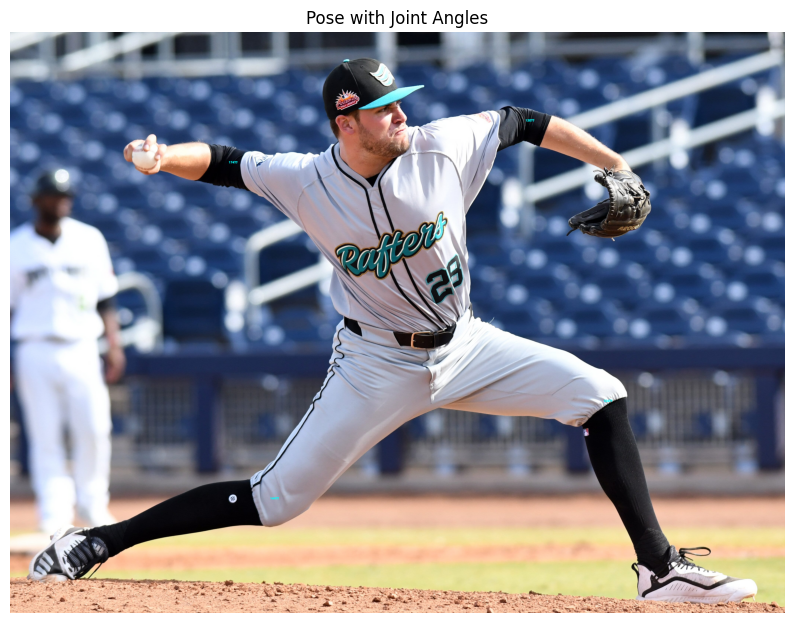

Calculated Joint Angles:
Right Elbow: 174.31°
Left Elbow: 130.23°
Right Knee: 144.87°
Left Knee: 124.96°


In [15]:
# Cell 7: Apply pose angle analysis and display the result

# Run MediaPipe Pose on the image again
with mp_pose.Pose(static_image_mode=True, model_complexity=2) as pose:
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Get annotated image and angles
annotated_image, angles = analyze_pose_angles(image, results)

# Show the annotated image with angles
plt.figure(figsize=[10, 10])
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title("Pose with Joint Angles")
plt.axis('off')
plt.show()

# Print joint angles
print("Calculated Joint Angles:")
for joint, angle in angles.items():
    print(f"{joint}: {angle:.2f}°")
